In [14]:
#%pip install yfinance
#%pip install pmdarima

In [15]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pmdarima as pm

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_hour = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

# Display the last five rows
prices = forex_data_hour['close']
prices

ERROR:tvDatafeed.main:error while signin


datetime
2024-08-23 06:15:00    2493.05
2024-08-23 06:30:00    2492.88
2024-08-23 06:45:00    2493.24
2024-08-23 07:00:00    2493.34
2024-08-23 07:15:00    2492.98
                        ...   
2024-10-23 18:15:00    2712.68
2024-10-23 18:30:00    2718.76
2024-10-23 18:45:00    2721.83
2024-10-23 19:00:00    2719.20
2024-10-23 19:15:00    2721.65
Name: close, Length: 4000, dtype: float64

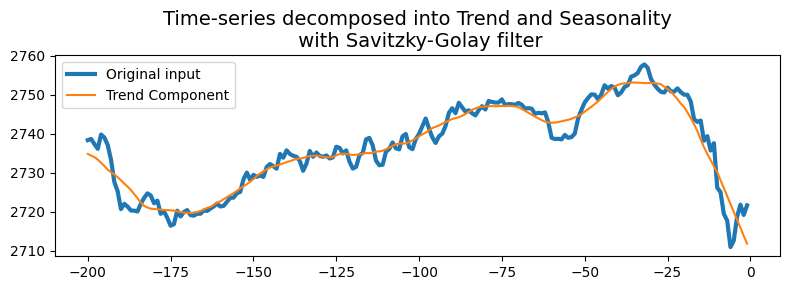

In [16]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [17]:
# Definition of Forecast Parameters
validation_elements = 0
forecast_elements = 40
seasonal_input_elements = 1600
visualization_elements = 120

# Trend - fit stepwise auto-ARIMA
smodel = pm.auto_arima(yvalues_trend, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
smodel.summary()

forecast = smodel.predict(n_periods=forecast_elements)

# Extend trend forecast
yvalues_trend_forecast = np.concatenate((yvalues_trend, forecast))
print(yvalues_trend_forecast[-forecast_elements:])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3536.492, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4940.216, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3529.896, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1187.703, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4997.095, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3537.218, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3536.856, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3533.712, Time=0.77 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3535.550, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3536.191, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3536.318, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3532.958, Time=2.51 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3537.592, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3537.081, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0

In [18]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

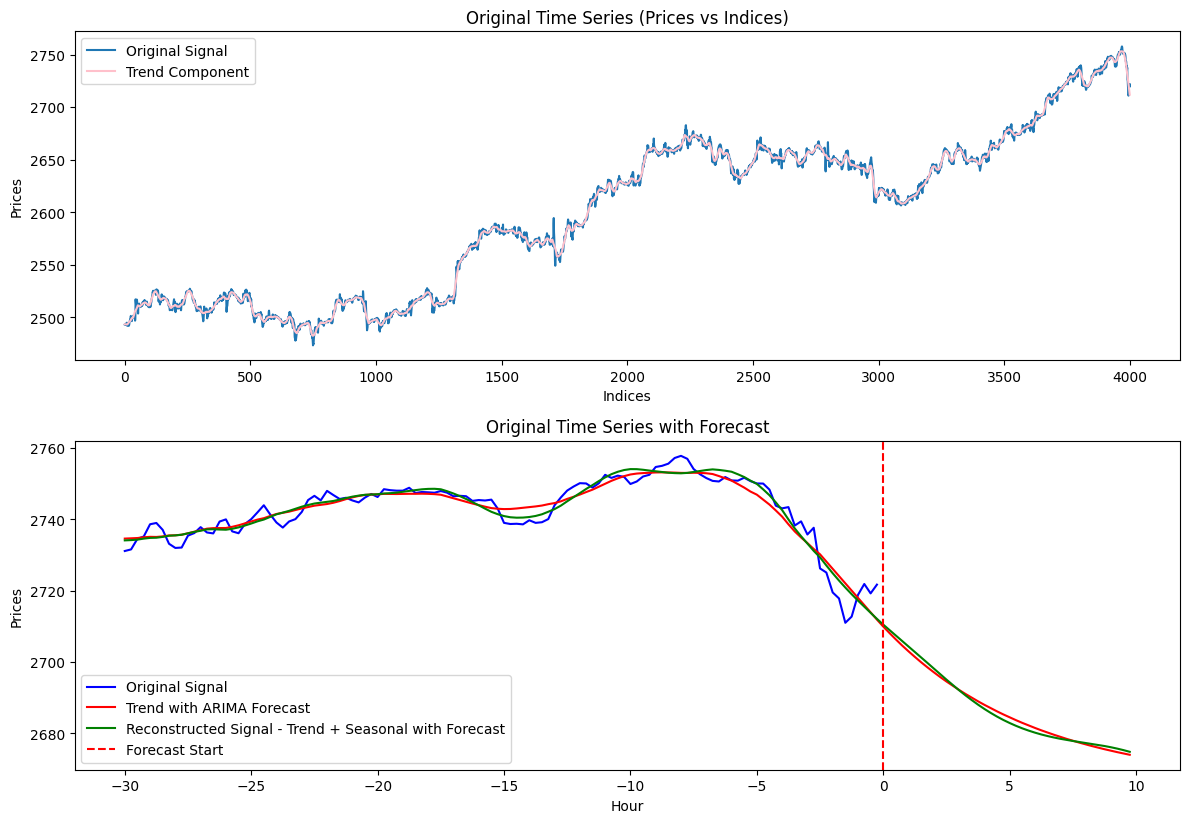

In [19]:
# 1. Correctly select the latest seasonal_input_elements

yvalues_seasonal_forecast, num_harmonics = fft_forecast(yvalues_seasonal[-seasonal_input_elements:], forecast_elements, 80)
# Plot

# Adjust data slices to match combined_indices length
prices_slice = prices[-visualization_elements:]
trend_slice = yvalues_trend_forecast[-(visualization_elements+forecast_elements):]
seasonal_slice = yvalues_seasonal_forecast[-(visualization_elements+forecast_elements):]

# **6b. Plotting**
plt.figure(figsize=(12, 12))

# Plot original signal and trend
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(prices)), prices, label="Original Signal")
plt.plot(np.arange(len(yvalues_trend)), yvalues_trend, label='Trend Component', color='pink')
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()
'''
# Plot reconstructed seasonal signal with forecast
plt.subplot(3, 1, 2)
plt.plot(np.arange(start_index, start_index + reconstructed_length), reconstructed_signal, label="Reconstructed Seasonal Signal + Forecast", color='orange')
plt.axvline(x=len(prices), color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Seasonal Signal with Forecast for Next {forecast_elements} Elements (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Amplitude")
plt.legend()
'''
# Plot combined trend and seasonal with forecast
plt.subplot(3, 1, 2)
plt.plot(np.arange(-visualization_elements,0)/4, prices_slice, label="Original Signal", color='blue')
plt.plot(np.arange(-visualization_elements,forecast_elements)/4, trend_slice, label="Trend with ARIMA Forecast", color='red')
plt.plot(np.arange(-visualization_elements,forecast_elements)/4, trend_slice+seasonal_slice, label="Reconstructed Signal - Trend + Seasonal with Forecast", color='green')
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.title("Original Time Series with Forecast")
plt.xlabel("Hour")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()
